<a href="https://colab.research.google.com/github/ShaoFuLiu/tSDRG_DataAnalysis/blob/master/TestSortingData_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **tSDRG Data Analysis**

### 1. **Before start plotting, please change the file path "my_metadata_file = ..." to your own metadata directory.**
### &emsp;*By defalt is for dropbox path.*
### 2. **Dim / Jdis = Dimerization / Randomness strength** 

### 3. **DimABC / JdisABC = Dimerization A.BC / Randomness strength A.BC**
### &emsp;*example: Dim123 = Dimerization 1.23*

# **Define metadata directory path**

In [2]:
## ------------------------------------------ Please change blow path to your own metadata directory path ------------------------------------------
my_metadata_file = '../tSDRG_metadata/Spin2/metadata/' ## Your local path (not necessary)
# my_metadata_file = './Spin2_metadata/' ## Defalt

# **Import lib and set basic parameter**

In [3]:
## Import library
import os
import math
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [4]:
## Basic parameter
cnames = {                        
'blueviolet':           '#8A2BE2',
'burlywood':            '#DEB887',
'cadetblue':            '#5F9EA0',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkorange':           '#FF8C00',
'dimgray':              '#696969',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'fuchsia':              '#FF00FF',
'gainsboro':            '#DCDCDC',
'gold':                 '#FFD700',
'greenyellow':          '#ADFF2F',
'honeydew':             '#F0FFF0',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'ivory':                '#FFFFF0',
'khaki':                '#F0E68C',
'orangered':            '#FF4500',
'orchid':               '#DA70D6'}
carr = []
for cmap in cnames.keys():                          ## color array
    carr.append(cmap)
marr = ['o-', '^-', 'x-', 's-', 'p-', '*-', 'h-']   ## marker array
marr_nl = ['o', '^', 'x', 's', 'p', '*', 'h']       ## marker array (no line)

spin = int(2)                                       ## Spin type
BC = 'PBC'                                          ## Boundary condition
P = 10                                              ## Random distribution type (10 == Exponential distribution)
M = 40                                              ## Bound dimension 
font_size = 30

ALL_Dimer = ["Dim000"]
ALL_Jdis = ["Jdis000"]

Ddiff = 1
init_D = 0      ## Dim000 = 0.00
final_D = 100   ## Dim100 = 1.00
ds = (final_D - init_D)/Ddiff-1
for i in range (int(ds)+1):
    strD = "Dim00" + str((i+1)*Ddiff+init_D)
    if ((i+1)*Ddiff+init_D >= 10):
        strD = "Dim0" + str((i+1)*Ddiff+init_D)
    if ((i+1)*Ddiff+init_D >= 100):
        strD = "Dim" + str((i+1)*Ddiff+init_D) 
    ALL_Dimer.append(strD)

Jdiff = 1
init_J = 0      ## Jdis000 = 0.00
final_J = 600   ## Jdis600 = 6.00
js = (final_J - init_J)/Jdiff-1
for i in range (int(js)+1):
    strJ = "Jdis00" + str((i+1)*Jdiff+init_J)
    if ((i+1)*Jdiff+init_J >= 10):
        strJ = "Jdis0" + str((i+1)*Jdiff+init_J)
    if ((i+1)*Jdiff+init_J >= 100):
        strJ = "Jdis" + str((i+1)*Jdiff+init_J)
    ALL_Jdis.append(strJ)
# print(ALL_Dimer) ## ALL_Dimer = [Dim000, Dim001, ... , Dim099, Dim100]
# print(ALL_Jdis)  ## ALL_Jdis = [Jdis000, Jdis001, ... , Jdis599, Jdis600]

# **Define function**

In [5]:
def find_id(f_diff): ## find crossing point index
    ids = []
    for id in range(len(f_diff)-1):
        if (np.sign(f_diff['diff'][id]) != np.sign(f_diff['diff'][id+1])):
            ids.append(id)
    if (len(ids) == 0):
        raise ValueError('no crossing point')
    return ids

def fitting_point(f_L1, f_L2, ids, var, para, n_point):
    x = []
    y = []
    for id in ids:   
        id_range = range(id-int(n_point/2-1), id+int(n_point/2)) ## use n point to fit (id-(n/2-1), ... id, ..., id+(n/2))

        a1, b1  = np.polyfit(f_L1[var][id_range], f_L1[para][id_range], 1)
        a2, b2  = np.polyfit(f_L2[var][id_range], f_L2[para][id_range], 1)
        x0 = (b2-b1)/(a1-a2)
        y0 = a1*x0 + b1
        x.append(x0)
        y.append(y0)
    return x,y

def fitting_point_slope(f_L1, f_L2, ids, var, para, n_point): ## return L1, L2 slope
    for id in ids:   
        id_range = range(id-int(n_point/2-1), id+int(n_point/2)) ## use n point to fit (id-(n/2-1), ... id, ..., id+(n/2))

        a1, b1  = np.polyfit(f_L1[var][id_range], f_L1[para][id_range], 1)
        a2, b2  = np.polyfit(f_L2[var][id_range], f_L2[para][id_range], 1)
    return a1,a2

# **Plot**

## Fix **<font color = red>L</font>**, look **<font color = yellow>J</font>**, **Order Parameter** vs **<font color = green>D</font>**

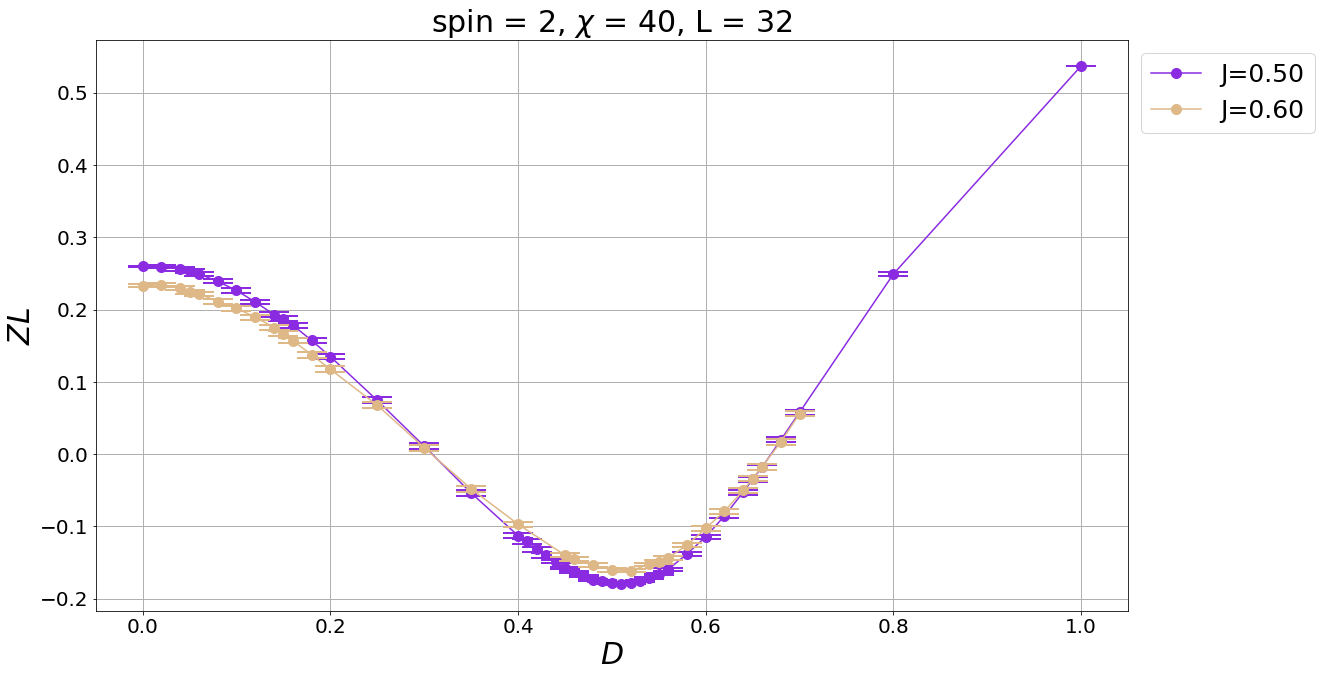

In [6]:
OrderPara = "ZL"   ## Choose SOP or ZL
Ls = [32]
# Dimer = ["Dim000","Dim002","Dim004","Dim006","Dim008","Dim010"]
Dimer = ALL_Dimer
Jdis = ["Jdis050","Jdis060"]

if (OrderPara == "SOP"):
    Para = "O^z"
    plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
if (OrderPara == "ZL"):
    Para = "ZL"
    plt.ylabel(r'$ZL$', fontsize=font_size)
    
for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])    

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            myfile = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                # print(dimer + ' does not exist!!!')
                continue
            
            df = pd.read_csv(myfile)

            if (OrderPara == "SOP" and spin == 2):
                mean = {'Dimer':D, Para:-1*df[Para][0], 'error':df["error"][0]}
            else:
                mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]}
                
            dfplt.loc[d] = mean
         
        plt.plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[j], markersize = font_size/3, label = 'J=%.2f' %(J))
        plt.errorbar(dfplt['Dimer'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=font_size/2, capthick=font_size/15, color=carr[j], label=None)
            
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.xlabel(r'$D$', fontsize=font_size)
# plt.xlim(0.9,1.2)  
# plt.ylim(0, 0.1)
#plt.xscale('log')
#plt.yscale('log')
plt.grid(linestyle='-', linewidth=1)
plt.title('spin = %s, $\chi$ = %d, L = %d' % (spin, M, L), fontsize=font_size)
plt.legend(bbox_to_anchor=(1, 1), loc = 'best',fontsize=font_size*5/6)
# plt.savefig( dimer + '_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

## Fix **<font color = red>L</font>**, look **<font color = green>D</font>**, **Order Parameter** vs **<font color = yellow>J</font>**

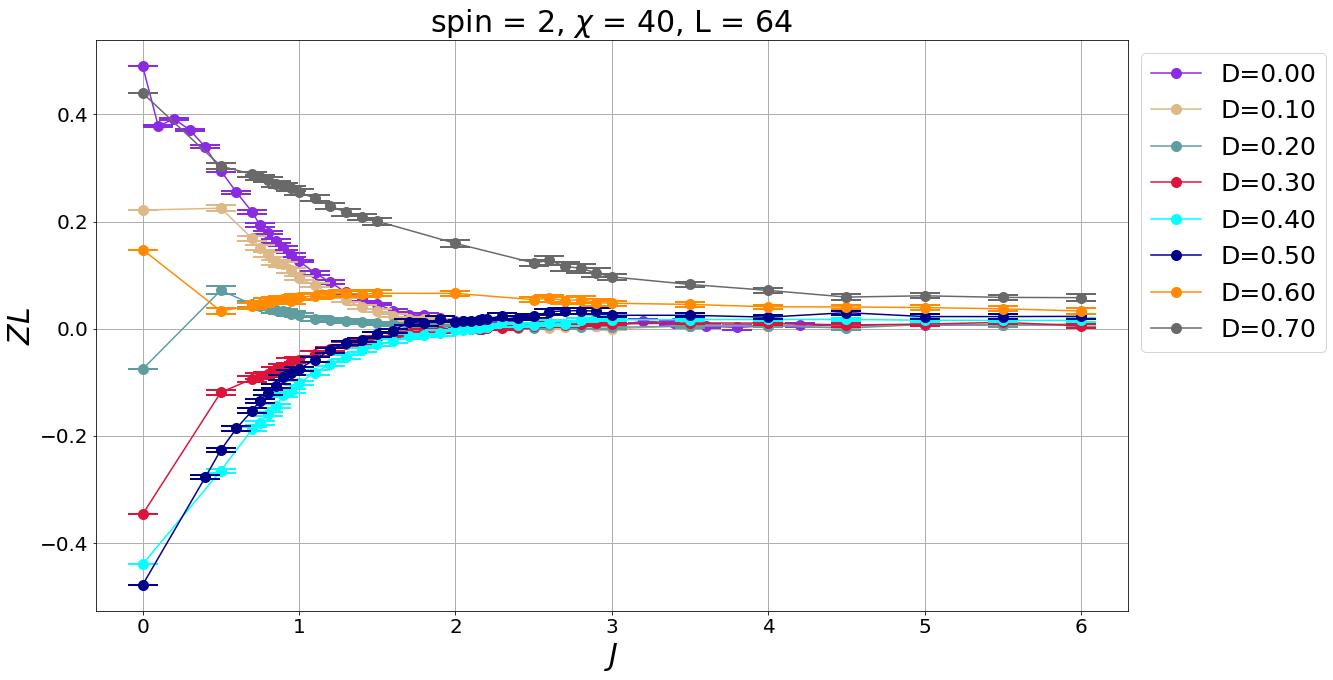

In [9]:
OrderPara = "ZL"  ## Choose SOP or ZL
Ls = [64]
Dimer = ["Dim000","Dim010","Dim020","Dim030","Dim040","Dim050","Dim060","Dim070"]
# Dimer = ["Dim000","Dim002","Dim004","Dim006","Dim008","Dim010"]
Jdis = ALL_Jdis

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'

for l in range(len(Ls)):
    L = Ls[l]
    
    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
            
            myfile = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                # print(dimer + ' does not exist!!!')
                continue
            
            df = pd.read_csv(myfile)

            if (OrderPara == "SOP" and spin == 2):
                mean = {'Jdis':J, Para:-1*df[Para][0], 'error':df["error"][0]}
            else:
                mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]}
            dfplt.loc[j] = mean

        plt.plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l+d], markersize = font_size/3, label = 'D=%.2f' %(D))
        plt.errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=font_size/2, capthick=font_size/15, color=carr[l+d], label=None)
            
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.xlabel(r'$J$', fontsize=font_size)
plt.ylabel(ylable, fontsize=font_size)
# plt.xlim(2.5,6)
# plt.ylim(0.0, 0.02)
#plt.xscale('log')
#plt.yscale('log')
plt.grid(linestyle='-', linewidth=1)
plt.title('spin = %s, $\chi$ = %d, L = %d' % (spin, M, L), fontsize=font_size)
plt.legend(bbox_to_anchor=(1, 1), loc = 'best',fontsize=font_size*5/6)
# plt.savefig( dimer + '_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()